In [14]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()

Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   created_at                  32092 non-null  datetime64[ns] 
 5   created_at_fe               21055 non-null  datetime64[ns] 
 6   amount                      32092 non-null  float64        
 7   fee                         21055 non-null  float64        
 8   stat_cr                     32092 non-null  object         
 9   stat_fe                     21055 non-null  object         
 10  transfer_type               32092 

In [25]:
# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Calcular métricas mensuales para ver morosidad
monthly_data = df_jo.groupby('Mes_created_at').agg(
    # Calcular total de fees que no han sido cobradas
    total_non_paid_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['rejected', 'cancelled'])].sum()),
    # Calcular total de fees que han sido fallidas (rejected y cancelled)
    total_confirmed_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['confirmed'])].sum()),
    
    # Calcular total de adelantos enviados, donde 'cash_request_received_date' no es nulo (ha sido recibido por el cliente)
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'stat_fe' != 'cancelled'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'cancelled'].sum()),
    # Calcular total de amount de cash_request adelantados donde 'status_cr' != 'money_back' y != 'active'
    total_cr_non_reimbur=('amount', lambda x: x[
        (df_jo.loc[x.index, 'stat_cr'] != 'money_back') & 
        (df_jo.loc[x.index, 'stat_cr'] != 'active') &
        (df_jo.loc[x.index, 'cash_request_received_date'].notnull())]
    .sum()
    )
).reset_index()

monthly_data

,Mes_created_at,total_non_paid_fees,total_confirmed_fees,total_adelantos,total_fees,total_cr_non_reimbur
0,2019-11,0.0,0.0,0.0,0.0,0.0
1,2019-12,0.0,0.0,16349.0,0.0,2259.0
2,2020-01,0.0,0.0,10579.0,0.0,850.0
3,2020-02,0.0,0.0,10625.0,0.0,1000.0
4,2020-03,0.0,0.0,16200.0,0.0,350.0
5,2020-04,5.0,0.0,31333.0,0.0,1400.0
6,2020-05,765.0,0.0,57223.0,545.0,3300.0
7,2020-06,4020.0,20.0,153973.0,5255.0,24260.0
8,2020-07,5185.0,45.0,184061.0,6240.0,33230.0
9,2020-08,5840.0,25.0,178451.0,12710.0,28465.0


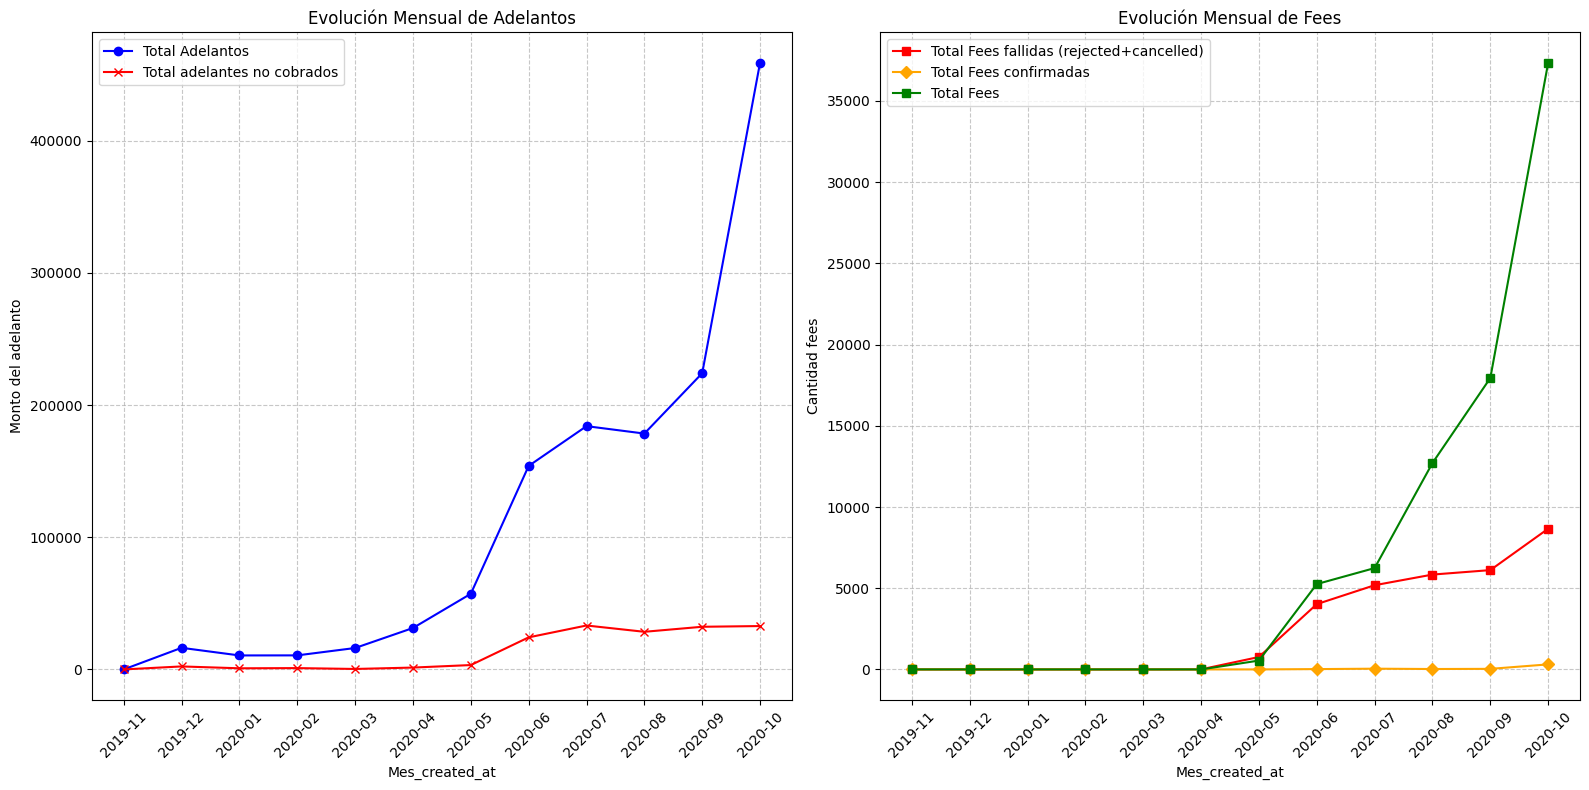

In [28]:
# Crear la figura y los ejes para dos gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# Asegurar la conversión adecuada del eje x
monthly_data['Mes_created_at'] = monthly_data['Mes_created_at'].astype(str)

# Graficar adelantos en el primer gráfico
ax1.plot(
    monthly_data['Mes_created_at'], 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax1.plot(
    monthly_data['Mes_created_at'], 
    monthly_data['total_cr_non_reimbur'], 
    marker='x', 
    label='Total adelantes no cobrados', 
    color='red'
)


# Configurar etiquetas y título para el gráfico de adelantos
ax1.set_xlabel('Mes_created_at')
ax1.set_ylabel('Monto del adelanto')
ax1.set_title('Evolución Mensual de Adelantos')
ax1.legend()  # Mostrar la leyenda para las líneas
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# Graficar fees en el segundo gráfico
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_non_paid_fees'], 
    marker='s', 
    label='Total Fees fallidas (rejected+cancelled)', 
    color='red'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_confirmed_fees'], 
    marker='D', 
    label='Total Fees confirmadas', 
    color='orange'
)
ax2.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'
)

# Configurar etiquetas y título para el gráfico de fees
ax2.set_xlabel('Mes_created_at')
ax2.set_ylabel('Cantidad fees')
ax2.set_title('Evolución Mensual de Fees')
ax2.legend()  # Mostrar la leyenda para las líneas
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', rotation=45)

# Ajustar el layout para que todo se vea bien
plt.tight_layout()

# Mostrar los gráficos
plt.show()


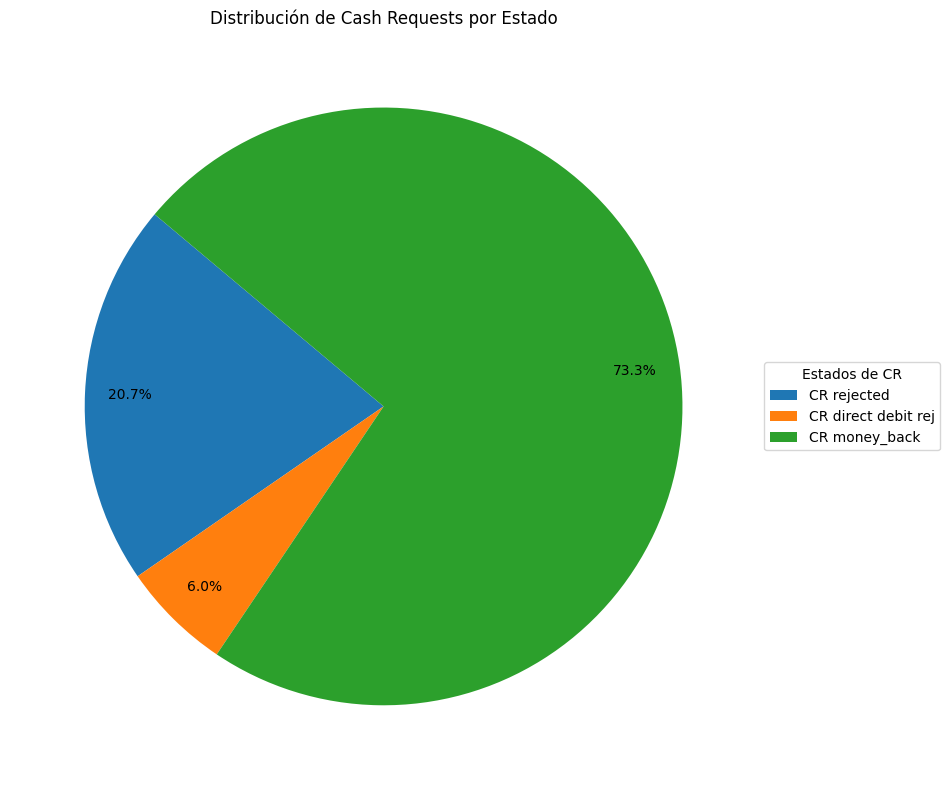

In [ ]:
# Preparamos datos para grafica pastel de amount cash_request

total_cr = df_jo['id_cr']
#total_approved_cr = df_jo.loc[df_jo['stat_cr'] == 'accepted', 'amount'].sum()
#total_canceled_cr = df_jo.loc[df_jo['stat_cr'] == 'canceled', 'amount'].sum()
#total_money_sent_cr = df_jo.loc[df_jo['stat_cr'] == 'money_sent', 'amount'].sum()
total_rejected_cr = df_jo.loc[df_jo['stat_cr'] == 'rejected', 'amount'].sum()
#total_pending_cr = df_jo.loc[df_jo['stat_cr'] == 'pending', 'amount'].sum()
#total_transaction_declined_cr = df_jo.loc[df_jo['stat_cr'] == 'transaction_declined', 'amount'].sum()
#total_waiting_user_information_cr = df_jo.loc[df_jo['stat_cr'] == 'waiting_user_confirmation', 'amount'].sum()
total_direct_debit_rejected_cr = df_jo.loc[df_jo['stat_cr'] == 'direct_debit_rejected', 'amount'].sum()
#total_waiting_reimbursement_cr = df_jo.loc[df_jo['stat_cr'] == 'waiting_reimbursement', 'amount'].sum()
#total_active_cr = df_jo.loc[df_jo['stat_cr'] == 'active', 'amount'].sum()
total_money_back_cr = df_jo.loc[df_jo['stat_cr'] == 'money_back', 'amount'].sum()
#total_direct_debit_sent_cr = df_jo.loc[df_jo['stat_cr'] == 'direct_debit_sent', 'amount'].sum()

#Dejamos solo las relevantes las demás no llegan a 1% ninguna

# Datos
labels = ['CR rejected', 'CR direct debit rej','CR money_back']
sizes = [total_rejected_cr,total_direct_debit_rejected_cr,total_money_back_cr]
colors = [
    "#1f77b4",  # Azul
    "#ff7f0e",  # Naranja
    "#2ca02c",  # Verde
    #"#d62728",  # Rojo
    #"#9467bd",  # Púrpura
    #"#8c564b",  # Marrón
    #"#e377c2",  # Rosa
    #"#7f7f7f",  # Gris
    #"#bcbd22",  # Amarillo oliva
    #"#17becf",  # Cian
    #"#ff9896",  # Rosa claro
    #"#aec7e8"   # Azul claro
]
#explode = (0.1, 0, 0)  # Explotar la primera porción (fees pagadas) para destacarla

# Crear gráfico de pastel sin etiquetas
plt.figure(figsize=(10, 8))
plt.pie(
    sizes, 
    colors=colors, 
    startangle=140, 
    autopct='%1.1f%%',  # Mostrar porcentajes
    pctdistance=0.85,  # Para que los porcentajes estén más cerca del centro
)

# Título
plt.title('Distribución de Cash Requests por Estado')

# Agregar leyenda a un lado
plt.legend(
    labels,  # Usar etiquetas de la lista 'labels'
    title='Estados de CR',
    loc='center left', 
    bbox_to_anchor=(1, 0.5),  # Coloca la leyenda a la derecha fuera del gráfico
    fontsize=10
)

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar el gráfico
plt.show()


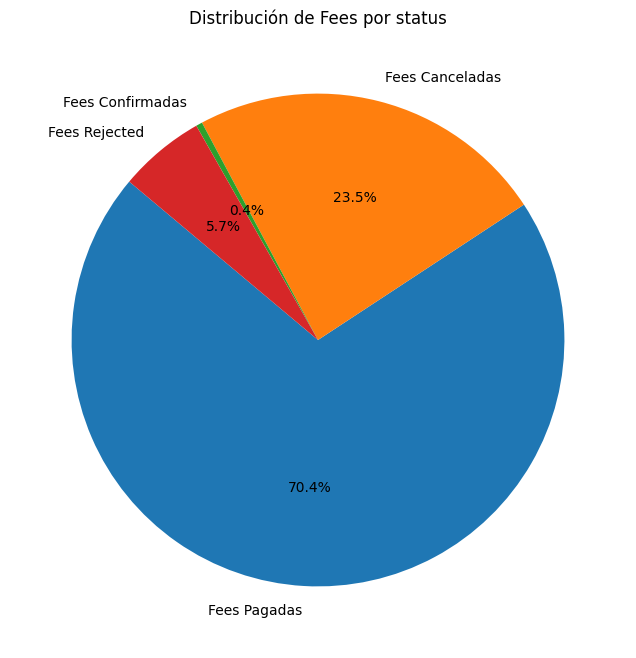

In [60]:
# Preparamos datos para grafica pastel de fees
total_fees = df_jo['fee']
total_paid_fees = df_jo.loc[df_jo['stat_fe'] == 'accepted', 'fee'].sum()
total_cancelled_fees = df_jo.loc[df_jo['stat_fe'] == 'cancelled', 'fee'].sum()
total_confirmed_fees = df_jo.loc[df_jo['stat_fe'] == 'confirmed', 'fee'].sum()
total_rejected_fees = df_jo.loc[df_jo['stat_fe'] == 'rejected', 'fee'].sum()

# Datos
labels = ['Fees Pagadas', 'Fees Canceladas', 'Fees Confirmadas', 'Fees Rejected']
sizes = [total_paid_fees, total_cancelled_fees, total_confirmed_fees, total_rejected_fees]
colors = [ "#1f77b4",  # Azul
    "#ff7f0e",  # Naranja
    "#2ca02c",  # Verde
    "#d62728",  # Rojo
    ]  # Colores para las diferentes categorías
#explode = (0.1, 0, 0)  # Explotar la primera porción (fees pagadas) para destacarla

# Crear gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, shadow=False)

# Título
plt.title('Distribución de Fees por status')

# Mostrar gráfico
plt.show()

In [139]:
# Definir fecha de referencia desde donde calculamos morosidad (mes a partir de la cual no tenemos datos)
fecha_referencia = pd.Timestamp("2020-12-01")

df_debt = df_jo[df_jo['cash_request_received_date'].notnull()]
df_debt= df_debt.copy()
# Calcular los días de deuda desde la fecha de referencia
df_debt['dias_deuda'] = (fecha_referencia - df_debt['cash_request_received_date']).dt.days


In [140]:
max_dias=print(morosos_time_analysis['total_dias_deuda'].max())

357.0


In [64]:
max_dias = morosos_time_analysis['total_dias_deuda'].max()

# Crear los bins correctamente en función de max_dias
if max_dias <= 30:
    bins = [0, max_dias + 1]
    labels = ['0-30 días']
elif max_dias <= 90:
    bins = [0, 30, max_dias + 1]
    labels = ['0-30 días', '31-90 días']
elif max_dias <= 180:
    bins = [0, 30, 90, max_dias + 1]
    labels = ['0-30 días', '31-90 días', '91-180 días']
elif max_dias <= 365:
    bins = [0, 30, 90, 180, max_dias + 1]
    labels = ['0-30 días', '31-90 días', '91-180 días', '181-365 días']
else:
    bins = [0, 30, 90, 180, 365, max_dias + 1]
    labels = ['0-30 días', '31-90 días', '91-180 días', '181-365 días', 'Más de 365 días']

# Aplicar el corte
morosos_time_analysis['rango_morosidad'] = pd.cut(
    morosos_time_analysis['total_dias_deuda'],
    bins=bins,
    labels=labels
)

morosos_time_analysis

,user_id,Mes_created_at,total_dias_deuda,total_dias_deuda_max,rango_morosidad
0,47,2020-04-01,228.0,228,181-365 días
1,47,2020-05-01,197.0,197,181-365 días
2,47,2020-08-01,118.0,118,91-180 días
3,47,2020-09-01,69.0,69,31-90 días
4,47,2020-10-01,37.5,47,31-90 días
...,...,...,...,...,...
15778,99030337,2020-07-01,133.0,133,91-180 días
15779,99030337,2020-10-01,55.0,55,31-90 días
15780,99030367,2020-10-01,34.0,34,31-90 días
15781,99030404,2020-10-01,39.0,39,31-90 días


In [136]:
# Contar la cantidad de usuarios únicos en cada rango
usuarios_por_rango = morosos_time_analysis.groupby('rango_morosidad')['user_id'].nunique().reset_index()
usuarios_por_rango.rename(columns={'user_id': 'cantidad_usuarios'}, inplace=True)
usuarios_por_rango

/tmp/ipykernel_186482/830689815.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usuarios_por_rango = morosos_time_analysis.groupby('rango_morosidad')['user_id'].nunique().reset_index()


,rango_morosidad,cantidad_usuarios
0,0-30 días,412
1,31-90 días,7247
2,91-180 días,3240
3,181-365 días,921


In [138]:
# Crear la figura
fig, ax = plt.subplots(figsize=(8, 4))  # Define el tamaño de la imagen

# Crear una tabla
ax.table(cellText=usuarios_por_rango.values, colLabels=usuarios_por_rango.columns, loc='center')

# Eliminar los ejes
ax.axis('off')

# Guardar la tabla como imagen
plt.savefig("usuarios_por_rangos.png", bbox_inches='tight', pad_inches=0.1)
plt.close()

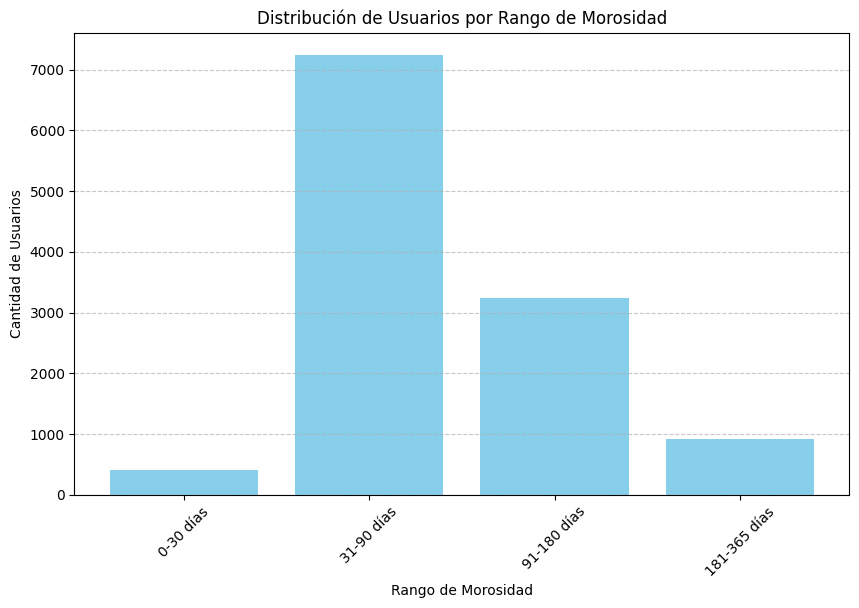

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(usuarios_por_rango['rango_morosidad'], usuarios_por_rango['cantidad_usuarios'], color='skyblue')
plt.title('Distribución de Usuarios por Rango de Morosidad')
plt.xlabel('Rango de Morosidad')
plt.ylabel('Cantidad de Usuarios')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Calcular la deuda promedio por rango de morosidad
deuda_promedio_por_rango = morosos_time_analysis.groupby('rango_morosidad')['total_dias_deuda'].mean().reset_index()
deuda_promedio_por_rango.rename(columns={'total_dias_deuda': 'dias_promedio_deuda'}, inplace=True)

deuda_promedio_por_rango


/tmp/ipykernel_186482/1313532394.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deuda_promedio_por_rango = morosos_time_analysis.groupby('rango_morosidad')['total_dias_deuda'].mean().reset_index()


,rango_morosidad,dias_promedio_deuda
0,0-30 días,27.213592
1,31-90 días,51.603333
2,91-180 días,134.193445
3,181-365 días,241.939904


In [76]:
# Filtrar por rango de morosidad '181-365 días'
df_rango_morosidad = morosos_time_analysis[morosos_time_analysis['rango_morosidad'] == '181-365 días']
cantidad_total_rango=df_rango_morosidad['user_id'].nunique()

# Filtrar por usuarios con user_id > 200000 que son los que tienen el user_id cancelado puesto que empiezan con 99+id_user
df_rango_morosidad_filtrado = df_rango_morosidad[df_rango_morosidad['user_id'] > 200000]

# Contar la cantidad de usuarios distintos en ese filtro
cantidad_usuarios = df_rango_morosidad_filtrado['user_id'].nunique()

print(f'Cantidad total de usuarios en rango morosidad 181-365 dias: {cantidad_total_rango}')
print(f"Cantidad de usuarios cancelados en el rango de morosidad 181-365 días: {cantidad_usuarios}")
print(f'Porcentaje de cancelados en rango morosos más alto:{(cantidad_usuarios/cantidad_total_rango)*100}%')


Cantidad total de usuarios en rango morosidad 181-365 dias: 921
Cantidad de usuarios cancelados en el rango de morosidad 181-365 días: 96
Porcentaje de cancelados en rango morosos más alto:10.423452768729643%


In [32]:
morosos_time_analysis = (
    df_debt.groupby(['user_id', 'Mes_created_at'], as_index=False)
    .agg(
        total_dias_deuda=('dias_deuda', 'mean'),  # Promedio de días que llevan debiendo dinero por mes y usuario
        total_dias_deuda_max=('dias_deuda', 'max')  # Máximo tiempo de deuda para casos extremos
    )
)
morosos_time_analysis

,user_id,Mes_created_at,total_dias_deuda,total_dias_deuda_max
0,47,2020-04,228.0,228
1,47,2020-05,197.0,197
2,47,2020-08,118.0,118
3,47,2020-09,69.0,69
4,47,2020-10,37.5,47
...,...,...,...,...
15778,99030337,2020-07,133.0,133
15779,99030337,2020-10,55.0,55
15780,99030367,2020-10,34.0,34
15781,99030404,2020-10,39.0,39


In [33]:
print(morosos_time_analysis['Mes_created_at'].dtype)

period[M]


In [119]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
df_jo

,id_cr,id_fe,fe_cr_id,user_id,created_at,created_at_fe,amount,fee,stat_cr,stat_fe,...,charge_moment,moderated_at,reason,category,from_date,to_date,recovery_status,Mes_created_at,cash_request_received_date,Cohorte
0,5,0,NaN,804,2019-12-10 19:05:21.596873,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 16:47:42.405646,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
1,70,0,NaN,231,2019-12-10 19:50:12.347780,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 14:24:22.897988,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
2,7,0,NaN,191,2019-12-10 19:13:35.825460,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 09:46:59.777728,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
3,10,0,NaN,761,2019-12-10 19:16:10.880172,NaT,99.0,NaN,rejected,NaN,...,NaN,2019-12-18 14:26:18.128407,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
4,1594,0,NaN,7686,2020-05-06 09:59:38.877376,NaT,100.0,NaN,rejected,NaN,...,NaN,2020-05-07 09:21:55.320193,NaN,NaN,NaT,NaT,nice,2020-05,NaT,2020-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,22357,15041,22357.0,82122,2020-10-20 07:58:04.006937,2020-10-20 07:58:19.637461,100.0,5.0,money_back,accepted,...,after,NaT,Instant Payment Cash Request 22357,nice,NaT,NaT,nice,2020-10,2020-10-21,2020-10
32088,20256,20325,20256.0,64517,2020-10-10 05:40:55.700422,2020-10-30 17:08:16.906449,100.0,5.0,money_back,accepted,...,before,NaT,Postpone Cash Request 20256,nice,2020-11-06 11:00:00,2020-12-07 11:00:00,nice,2020-10,2020-10-12,2020-10
32089,20256,12366,20256.0,64517,2020-10-10 05:40:55.700422,2020-10-10 05:42:11.679401,100.0,5.0,money_back,accepted,...,after,NaT,Instant Payment Cash Request 20256,nice,NaT,NaT,nice,2020-10,2020-10-12,2020-10
32090,19886,12513,19886.0,44867,2020-10-08 14:16:52.155661,2020-10-10 21:22:00.083739,100.0,5.0,direct_debit_sent,accepted,...,before,NaT,Postpone Cash Request 19886,nice,2020-11-06 22:00:00,2020-12-06 11:00:00,nice,2020-10,2020-10-10,2020-09


In [109]:
# Calcular métricas mensuales para ver morosidad
cohort_risk_data = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(
    # Sumar los valores de 'fee' donde 'stat_fe' es igual a 'accepted'
    total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
    # Calcular total de fees que no han sido cobradas
    #total_non_paid_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['rejected', 'cancelled'])].unique().sum()),
    # Calcular total de fees que han sido fallidas (rejected y cancelled)
    total_confirmed_fees = ('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'].isin(['confirmed'])].sum()),
    
    # Calcular total de adelantos enviados, donde 'cash_request_received_date' no es nulo (ha sido recibido por el cliente)
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'stat_fe' != 'cancelled'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'cancelled'].sum()),
    # Calcular total de amount de cash_request adelantados donde 'status_cr' != 'money_back' y != 'active'
    total_cr_non_reimbur=('amount', lambda x: x[
        (df_jo.loc[x.index, 'stat_cr'] != 'money_back') & 
        (df_jo.loc[x.index, 'stat_cr'] != 'active') &
        (df_jo.loc[x.index, 'cash_request_received_date'].notnull())]
    .sum()   
    )
).reset_index()

cohort_risk_data['total_non_paid_fees'] = cohort_risk_data['total_fees'] - cohort_risk_data['total_paid_fees']
cohort_risk_data['non_paid_fees_percent']= (cohort_risk_data['total_non_paid_fees']/cohort_risk_data['total_fees'])
cohort_risk_data['non_paid_cr_percent']= (cohort_risk_data['total_cr_non_reimbur']/cohort_risk_data['total_adelantos'])


cohort_risk_data

,Cohorte,Mes_created_at,total_paid_fees,total_confirmed_fees,total_adelantos,total_fees,total_cr_non_reimbur,total_non_paid_fees,non_paid_fees_percent,non_paid_cr_percent
0,2019-11,2019-11,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,2019-11,2019-12,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,2019-11,2020-04,0.0,0.0,100.0,0.0,0.0,0.0,NaN,0.000000
3,2019-11,2020-05,5.0,0.0,10.0,5.0,0.0,0.0,0.000000,0.000000
4,2019-11,2020-08,10.0,0.0,10.0,10.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
68,2020-08,2020-09,1265.0,5.0,16170.0,1370.0,3450.0,105.0,0.076642,0.213358
69,2020-08,2020-10,1150.0,0.0,17330.0,1195.0,680.0,45.0,0.037657,0.039238
70,2020-09,2020-09,8215.0,5.0,98731.0,8875.0,19690.0,660.0,0.074366,0.199431
71,2020-09,2020-10,3175.0,5.0,40810.0,3440.0,3760.0,265.0,0.077035,0.092134


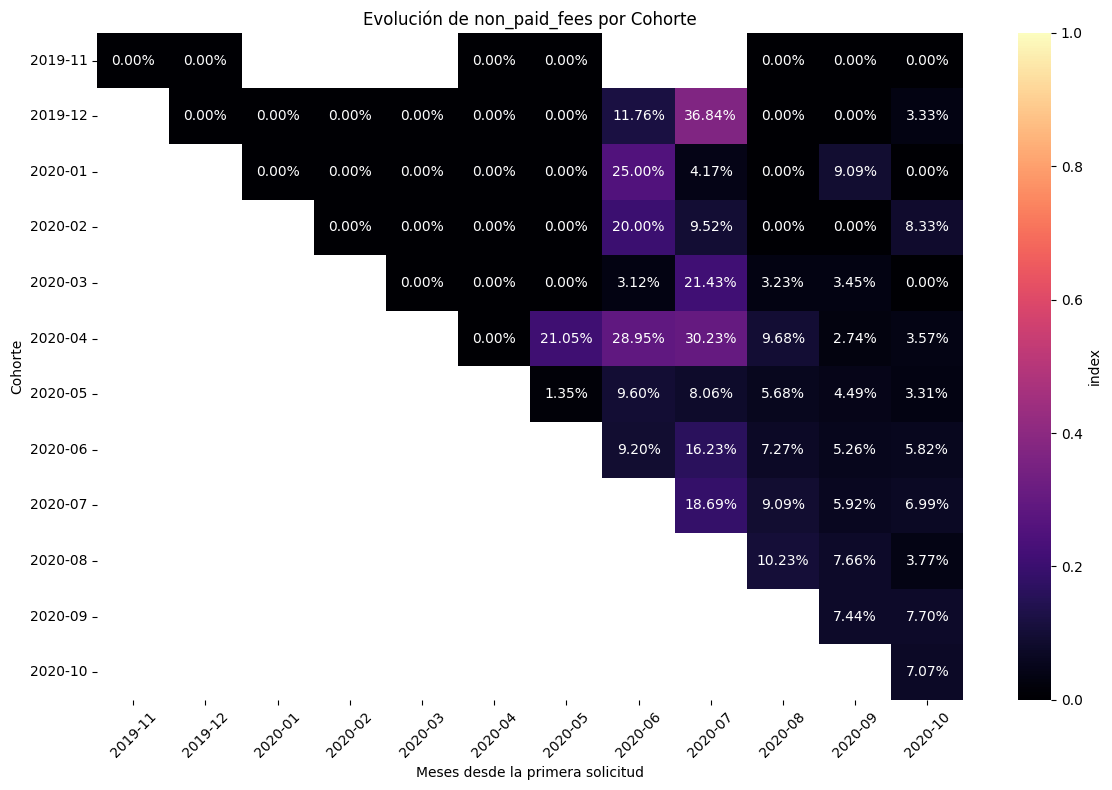

In [111]:
cohort_risk_data.fillna(0, inplace=True)

# Pivotar los datos para crear una matriz de index por cohorte para cada mes
non_paid_fees_heatmap_data = cohort_risk_data.pivot(index='Cohorte', columns='Mes_created_at', values='non_paid_fees_percent')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(non_paid_fees_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='magma', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución de non_paid_fees por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()


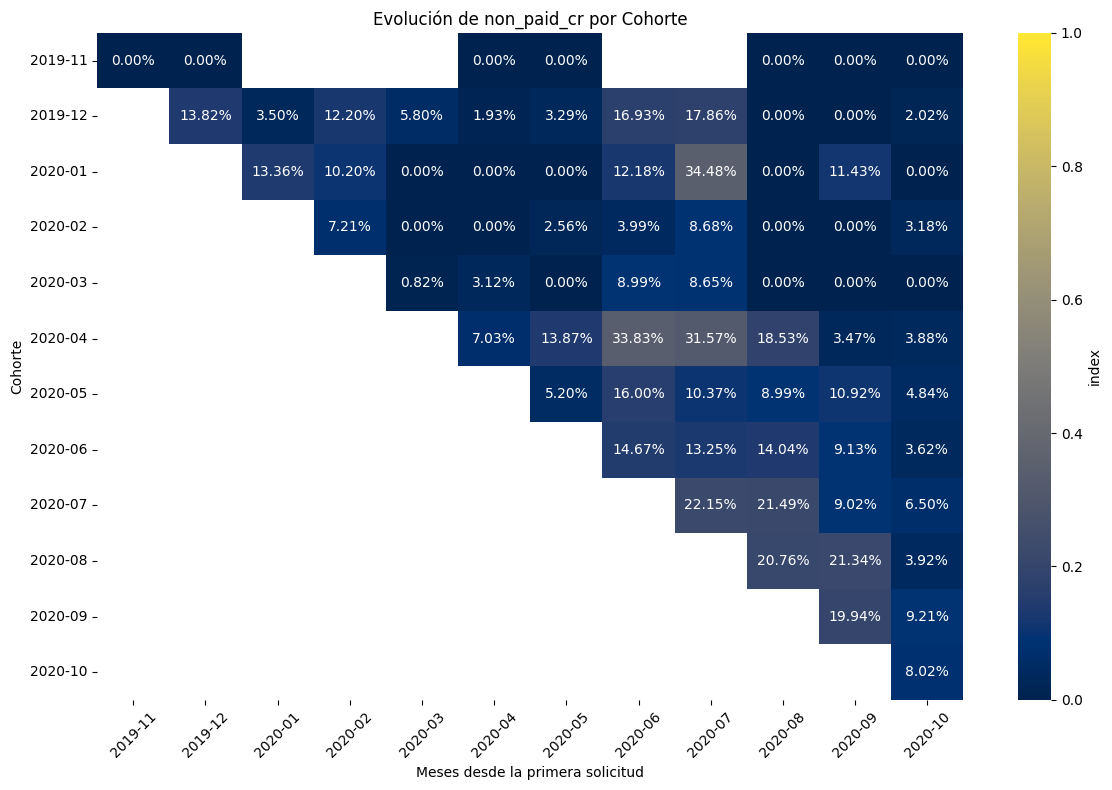

In [105]:
cohort_risk_data.fillna(0, inplace=True)

# Pivotar los datos para crear una matriz de index por cohorte para cada mes
non_paid_fees_heatmap_data = cohort_risk_data.pivot(index='Cohorte', columns='Mes_created_at', values='non_paid_cr_percent')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(non_paid_fees_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='cividis', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución de non_paid_cr por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()

In [132]:
# Filter for Cohorte '2020-04' and calculate unique id_cr sums per user and month
cr_non_paid_2020_04 = (
    df_jo[
        (df_jo['Cohorte'] == '2020-04') &  # Filter cohort
        (df_jo['stat_cr'] != 'money_back') & 
        (df_jo['stat_cr'] != 'active') &
        (df_jo['cash_request_received_date'].notna())  # Ensure cash_request_received_date is not null
    ]
    .drop_duplicates(subset=['user_id', 'Mes_created_at', 'id_cr'])  # Remove duplicate id_cr
    .groupby(['user_id', 'Mes_created_at'])['amount']
    .sum()
    .reset_index()
)

# Filtrar los 10 peores usuarios por el total de amount
cohort_amount_2020_04_worst10 = cr_non_paid_2020_04.sort_values(by='amount', ascending=False).head(10)

# Pivot to show months as columns
cohort_amount_2020_04_worst10 = cohort_amount_2020_04_worst10.pivot(index='user_id', columns='Mes_created_at', values='amount')

# Display the result
cohort_amount_2020_04_worst10



Mes_created_at,2020-04,2020-05,2020-06,2020-07,2020-08
user_id,,,,,
2860,100.0,NaN,NaN,NaN,NaN
4552,NaN,100.0,100.0,NaN,NaN
4723,100.0,NaN,NaN,NaN,NaN
4869,NaN,NaN,NaN,100.0,NaN
4906,NaN,NaN,NaN,NaN,100.0
4973,NaN,NaN,NaN,NaN,100.0
5015,NaN,NaN,100.0,NaN,NaN
5185,100.0,NaN,NaN,NaN,NaN
5241,100.0,NaN,NaN,NaN,NaN


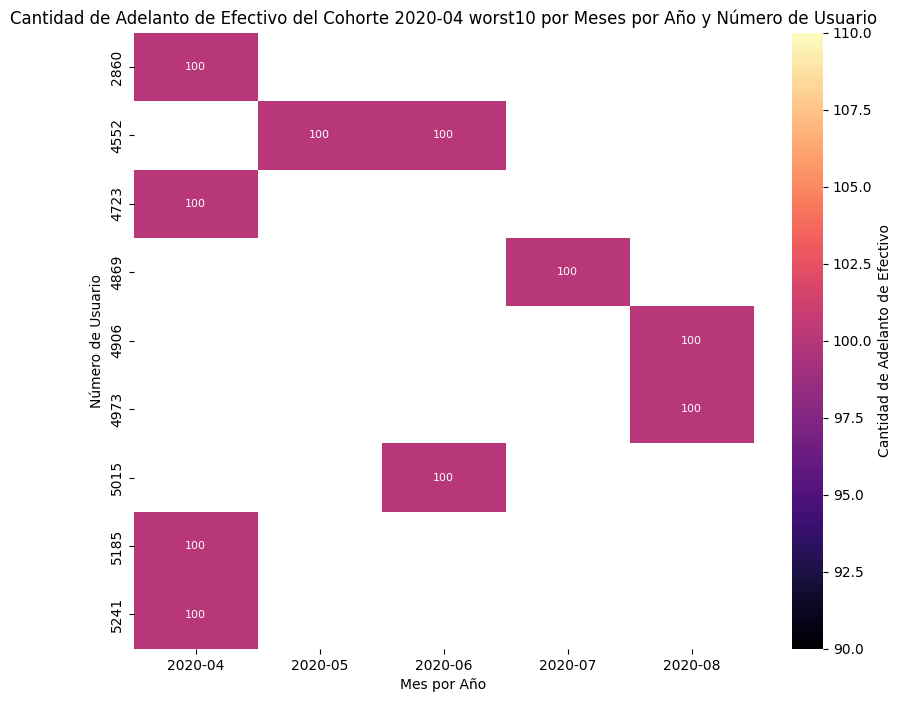

In [133]:
# Graficar la cantidad de adelanto de efectivo de la cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-04 worst10 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_04_worst10, annot=True, fmt='.0f', cmap='magma', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

In [134]:
# Filter for Cohorte '2020-07' and calculate unique id_cr sums per user and month
cr_non_paid_2020_07 = (
    df_jo[
        (df_jo['Cohorte'] == '2020-07') &  # Filter cohort
        (df_jo['stat_cr'] != 'money_back') & 
        (df_jo['stat_cr'] != 'active') &
        (df_jo['cash_request_received_date'].notna())  # Ensure cash_request_received_date is not null
    ]
    .drop_duplicates(subset=['user_id', 'Mes_created_at', 'id_cr'])  # Remove duplicate id_cr
    .groupby(['user_id', 'Mes_created_at'])['amount']
    .sum()
    .reset_index()
)

# Filtrar los 10 peores usuarios por el total de amount
cohort_amount_2020_07_worst10 = cr_non_paid_2020_07.sort_values(by='amount', ascending=False).head(10)

# Pivot to show months as columns
cohort_amount_2020_07_worst10 = cohort_amount_2020_07_worst10.pivot(index='user_id', columns='Mes_created_at', values='amount')

# Display the result
cohort_amount_2020_07_worst10

Mes_created_at,2020-07,2020-08,2020-10
user_id,,,
4305,100.0,NaN,NaN
5206,100.0,NaN,NaN
5223,NaN,NaN,100.0
6765,NaN,100.0,NaN
8866,NaN,100.0,NaN
11657,NaN,100.0,NaN
11832,NaN,NaN,100.0
12699,100.0,NaN,NaN
12710,100.0,NaN,NaN


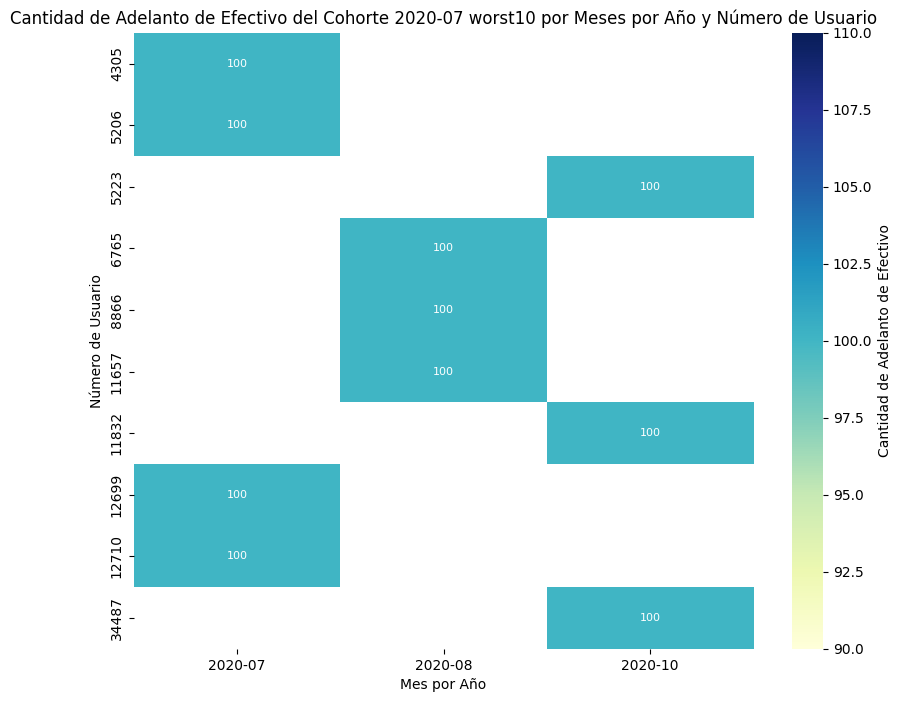

In [135]:
# Graficar la cantidad de adelanto de efectivo de la cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-07 worst10 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_07_worst10, annot=True, fmt='.0f', cmap='YlGnBu', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()